In [1]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거


In [2]:
##### (1)

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]


# New MF class for training & testing
class NEW_MF:
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        ##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        #### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = (
            self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        )
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = r - prediction

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])

    ##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):  # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0  # Setting test set ratings to 0
        self.test_set = test_set
        return test_set  # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error / len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1.0 / self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0 / self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i + 1, rmse1, rmse2))
            if self.verbose:
                if (i + 1) % 10 == 0:
                    print(
                        "Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f"
                        % (i + 1, rmse1, rmse2)
                    )
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(
            self.user_id_index[user_id], self.item_id_index[item_id]
        )

    # Full user-movie rating matrix
    def full_prediction(self):
        return (
            self.b
            + self.b_u[:, np.newaxis]
            + self.b_d[np.newaxis, :]
            + self.P.dot(self.Q.T)
        )


##### <<<<< (3)

K = 50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9240 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9197 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9163 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9133 ; Test RMSE = 0.9465
Iteration: 80 ; Train RMSE = 0.9102 ; Test RMSE = 0.9453
Iteration: 90 ; Train RMSE = 0.9066 ; Test RMSE = 0.9441
Iteration: 100 ; Train RMSE = 0.9019 ; Test RMSE = 0.9427
Iteration: 110 ; Train RMSE = 0.8956 ; Test RMSE = 0.9407
Iteration: 120 ; Train RMSE = 0.8870 ; Test RMSE = 0.9379
Iteration: 130 ; Train RMSE = 0.8757 ; Test RMSE = 0.9344
Iteration: 140 ; Train RMSE = 0.8619 ; Test RMSE = 0.9304
Iteration: 150 ; Train RMSE = 0.8461 ; Test RMSE = 0.9264
Iteration: 160 ; Train RMSE = 0.8288 ; Test RMSE = 0.9229
Iteration: 170 ; Train RMSE = 0.8104 ; Test RMSE = 0.9200
Iteration: 180 ;

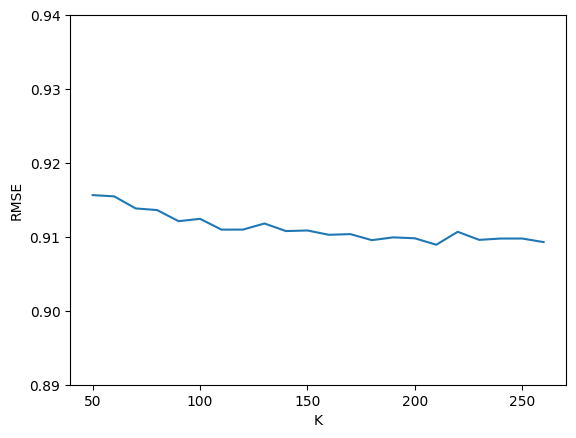

In [3]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50, 261, 10):
    print("K =", K)
    R_temp = ratings.pivot(index="user_id", columns="movie_id", values="rating").fillna(
        0
    )
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j + 1, RMSE[j]])

# 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()

In [6]:
results

[[(1, 1.0781633684251697, 1.081564554387901),
  (2, 1.0475110938613341, 1.053320328379241),
  (3, 1.026317128009717, 1.034239482133087),
  (4, 1.0107671073424498, 1.0205632896169257),
  (5, 0.9989277632653407, 1.0103856340036386),
  (6, 0.9895990159870913, 1.0025220916310398),
  (7, 0.9820635227717919, 0.9962733493328675),
  (8, 0.9758308151510774, 0.9911885825737784),
  (9, 0.9705871982230695, 0.9869549053958143),
  (10, 0.9661064630969088, 0.9833977862079238),
  (11, 0.9622204839426544, 0.9803338839248941),
  (12, 0.9588176745406043, 0.9776835155223921),
  (13, 0.9557986240195941, 0.9753467370151883),
  (14, 0.9531042771516588, 0.9732901997836616),
  (15, 0.9506790592944773, 0.9714381747095542),
  (16, 0.9484815552008922, 0.9697829959365833),
  (17, 0.9464836602137434, 0.9682642598979839),
  (18, 0.944650894854536, 0.9668847574980294),
  (19, 0.9429628135892595, 0.9656350055079912),
  (20, 0.9414047050498099, 0.9644727715327096),
  (21, 0.9399587439632814, 0.9634061108503451),
  (22,

In [5]:
summary

[[50, 204, 0.9156502413301066],
 [60, 212, 0.9154821181635121],
 [70, 215, 0.913851514226575],
 [80, 222, 0.9136269853248999],
 [90, 227, 0.9121239143682855],
 [100, 230, 0.912441110267347],
 [110, 236, 0.9109812373480983],
 [120, 238, 0.9109867275015822],
 [130, 240, 0.9118098087934872],
 [140, 243, 0.9107877564365839],
 [150, 244, 0.9108664853381871],
 [160, 247, 0.9102825777877159],
 [170, 248, 0.9103741397130851],
 [180, 251, 0.9095576413705017],
 [190, 251, 0.9099342975943135],
 [200, 254, 0.9098105806694919],
 [210, 256, 0.9089371869823935],
 [220, 257, 0.9106883221986495],
 [230, 258, 0.9095959826455753],
 [240, 259, 0.9097756775699014],
 [250, 259, 0.9097779885194224],
 [260, 261, 0.9092951902811166]]